In [37]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Here we are looking for what flux sector the ground state is in for a given unit cell.  
We do this the stupid way, by exhaustively looking over the entire flux space and then picking the lowest energy we found.

The working hypothesis is:\
all 4,8,12,16 ... sided faces have flux -1\
all 6,10,14,18 ... sided faces have flux +1

all the odd sided faces can either be + or - 1 BUT they alternate,\
i.e. if the 5s are +1 then the 7s are -1 and the 9's are +1 etc etc

if you find a counter example to this rule themn Peru owes you a pint

In [38]:
from koala.example_graphs import *
from matplotlib import pyplot as plt
from koala.pointsets import generate_random
from koala import plotting as pl
from koala.graph_color import color_lattice
from koala.flux_finder import fluxes_from_bonds, fluxes_to_labels, n_to_ujk_flipped
from koala.phase_space import k_hamiltonian_generator, analyse_hk, gap_over_phase_space
from numpy import linalg as la
from tqdm import tqdm
from koala.graph_utils import plaquette_spanning_tree
import matplotlib
matplotlib.rcParams.update({'font.size': 12, 'text.usetex': True, 'font.family': 'serif', 'font.serif': ['Computer Modern'], 'figure.figsize': (10,10)})

Define the unit cell here:

In [39]:
# define the lattice system
number_of_plaquettes = 13
plaquette_range = 8

# keep finding new lattices until you get one with a good range of plaquette sizes! (there is definitely a beter way to do this)
number_of_plaque_sizes = 0
tested = 0
while number_of_plaque_sizes < plaquette_range :
    tested += 1
    points = generate_random(number_of_plaquettes)
    lattice = generate_lattice(points)
    all_sides = np.array([lattice.plaquettes[n].n_sides for n in range(len(lattice.plaquettes))])
    number_of_plaque_sizes = len(np.unique(all_sides))


# color the lattice
coloring = color_lattice(lattice)
print(f'We tested {tested} lattices')




We tested 140 lattices


Plot the default flux config

Text(0.5, 1.0, 'Distribution of n-gons in lattice')

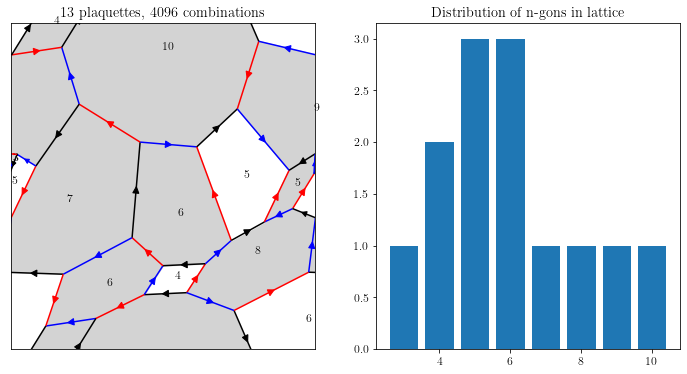

In [40]:
ujk = np.full(lattice.n_edges, 1)
J = np.array([1,1,1])

# find fluxes
fluxes = fluxes_from_bonds(lattice, ujk)

# plot it
fig, axes = plt.subplots(1,2,figsize = (12,6))
ax, ax2 = axes
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
pl.plot_edges(lattice, ax= ax,labels=coloring, directions=ujk)
pl.plot_plaquettes(lattice, ax= ax, labels = fluxes_to_labels(fluxes), color_scheme=np.array(['w','lightgrey']))
# pl.plot_edge_indices(lattice)
ax.set_title(f'{lattice.n_plaquettes} plaquettes, {2**(lattice.n_plaquettes -1)} combinations')

# find how many n-gons there are and plot that
all_sides = np.array([lattice.plaquettes[n].n_sides for n in range(len(lattice.plaquettes))])
all_centers = np.array([lattice.plaquettes[n].center for n in range(len(lattice.plaquettes))])
for n in range(all_sides.__len__()):
    ax.text(all_centers[n,0], all_centers[n,1], all_sides[n])
counts = np.bincount(all_sides)
ax2.bar(np.arange(len(counts))[3:], counts[3:])
ax2.set_title('Distribution of n-gons in lattice')


Plot an example gap structure in k

(-0.7581832088468494, 5.73408277892689e-16)


Text(0, 0.5, '$k_y$')

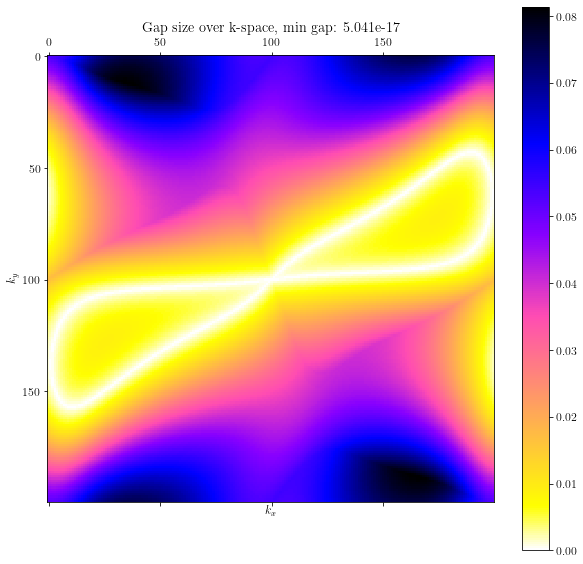

In [41]:

resolution = 200

# find the gap size over k space
Hk = k_hamiltonian_generator(lattice, coloring,ujk,J)
print(analyse_hk(Hk, resolution))
g = gap_over_phase_space(Hk, resolution)

fig, ax = plt.subplots(figsize = (10,10))
cax = ax.matshow(g, cmap = 'gnuplot2_r',vmin = 0)
plt.colorbar(cax,ax=ax)
ax.set_title(f'Gap size over k-space, min gap: {np.min(g):.3e}')
ax.set_xlabel('$k_x$')
ax.set_ylabel('$k_y$')

Exhaustively search the flux space with flux averaging. if you get weird results try turning up the resolution and see if they don't go away

In [42]:
# resolution in k space - if this is too low you get wird results as youre not sampling k space enough
resolution = 50

# find the minimum spanning tree
min_spanning_set = plaquette_spanning_tree(lattice)
n_in_tree =  len(min_spanning_set)


# we want the energy and gap size for every flux sector
energies = []; gaps = []

# search over every possible combination of ujk flips - looks exhaustively over the whole flux space 
for val in tqdm(range(2**n_in_tree)):

    new_ujk = n_to_ujk_flipped(val, ujk, min_spanning_set)

    Hk = k_hamiltonian_generator(lattice, coloring,new_ujk,J)
    
    e, g = analyse_hk(Hk, resolution)
    energies.append(e)
    gaps.append(g)
    
energies = np.array(energies)
gaps = np.array(gaps)

100%|██████████| 4096/4096 [17:01<00:00,  4.01it/s]


Text(0.5, 1.0, 'Gap Size')

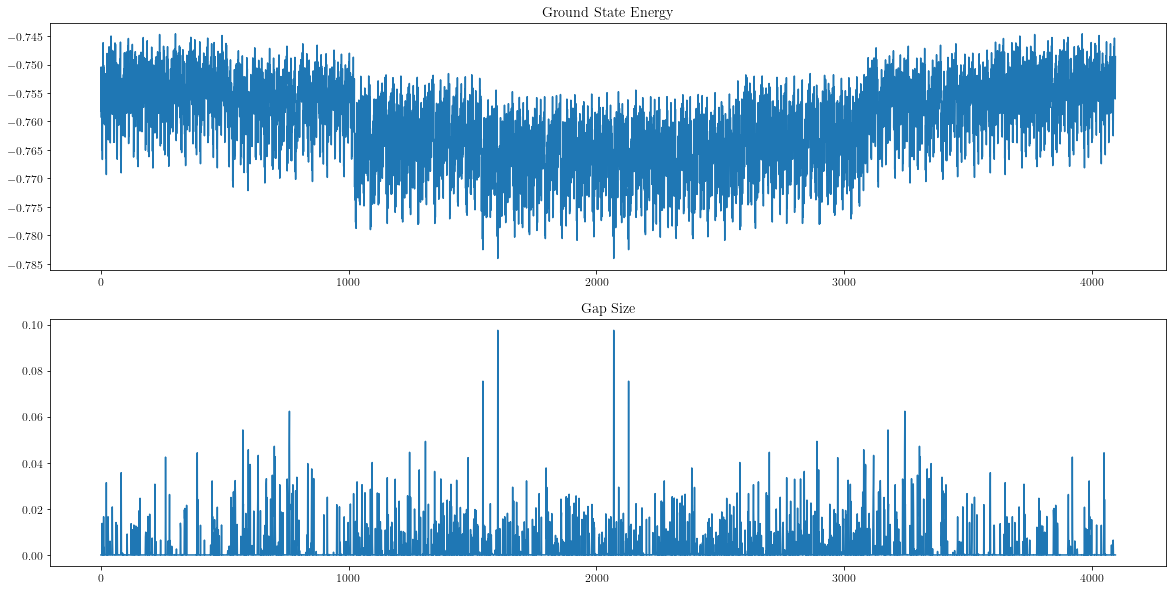

In [43]:
# make a plot showing the gnd state energy and gap size for every flux sector
fig, ax = plt.subplots(2,1, figsize = (20,10))
ax[0].plot(energies)
ax[1].plot(gaps)
ax[0].set_title('Ground State Energy')
ax[1].set_title('Gap Size')

Now we plot the winning flux sector, plaquette face number is printed in the middle of each plaquette so you check the flux sector is right

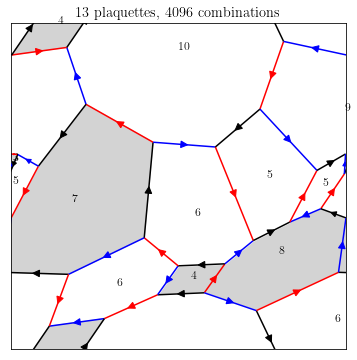

In [48]:
# find the lowerst energy flux sector
winner = np.argmin(energies)

# plot the winning flux sector
ujk_winner = n_to_ujk_flipped(winner, ujk, min_spanning_set)
fluxes = fluxes_from_bonds(lattice, ujk_winner)
fig, ax = plt.subplots(figsize = (6,6))
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
pl.plot_edges(lattice, ax= ax,labels=coloring, directions=ujk_winner)
pl.plot_plaquettes(lattice,labels = fluxes_to_labels(fluxes), color_scheme=np.array(['w','lightgrey']))
ax.set_title(f'{lattice.n_plaquettes} plaquettes, {2**(lattice.n_plaquettes -1)} combinations')

all_sides = np.array([lattice.plaquettes[n].n_sides for n in range(len(lattice.plaquettes))])
all_centers = np.array([lattice.plaquettes[n].center for n in range(len(lattice.plaquettes))])
for n in range(all_sides.__len__()):
    plt.text(all_centers[n,0], all_centers[n,1], all_sides[n])



Now we plot the 100 lowest energy flux sectors - looking at energy and gap size for each one

flux gap: 0.0015 
fermion gap: 0.0975


Text(0.5, 1.0, 'Gap of lowest 100 flux states')

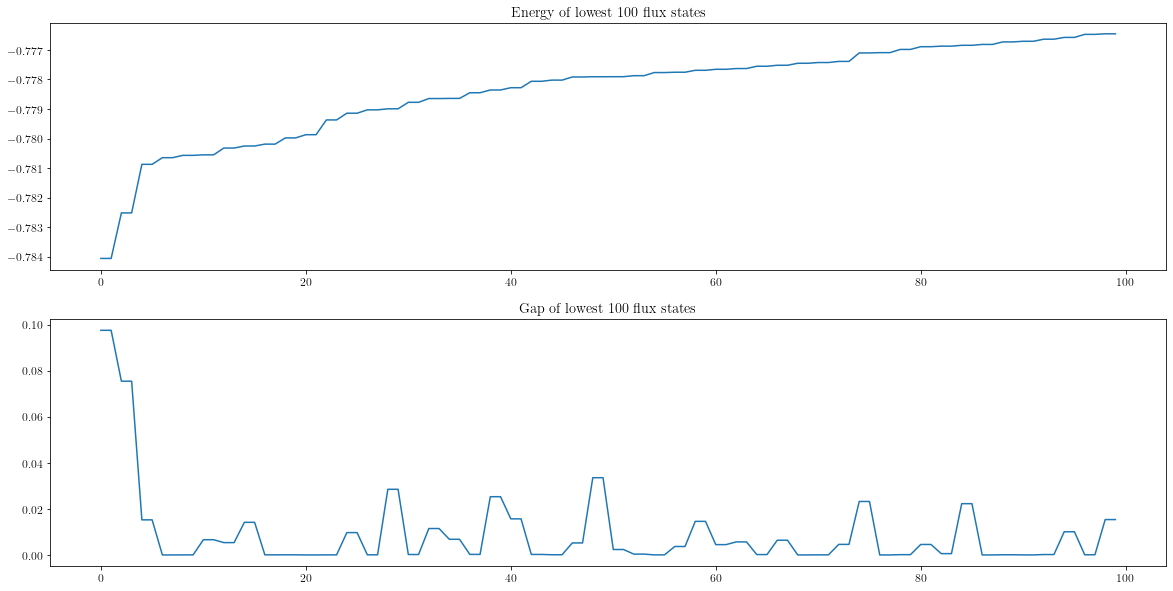

In [49]:
# now we compare the size of the flux gap with the energy gap of the zero flux sector
sorted_list = np.argsort(energies)
sorted_energies = energies[sorted_list]
flux_gap = sorted_energies[2] - sorted_energies[0]
print(f'flux gap: {flux_gap:.4f} \nfermion gap: {gaps[winner]:.4f}')

# plot gap size and energy of the lowest [n] energy states
sorted_gaps = gaps[sorted_list]

# number of states
limit = 100
fig, ax = plt.subplots(2,1,figsize= (20,10))
ax[0].plot(sorted_energies[:limit], label= 'energies')
ax[1].plot(sorted_gaps[:limit], label= 'gaps')
ax[0].set_title(f'Energy of lowest {limit} flux states')
ax[1].set_title(f'Gap of lowest {limit} flux states')


Have a look at the gap over k space for the lowest energy flux sector

(-0.7840569235839666, 0.09750119211762075)


Text(0, 0.5, '$k_y$')

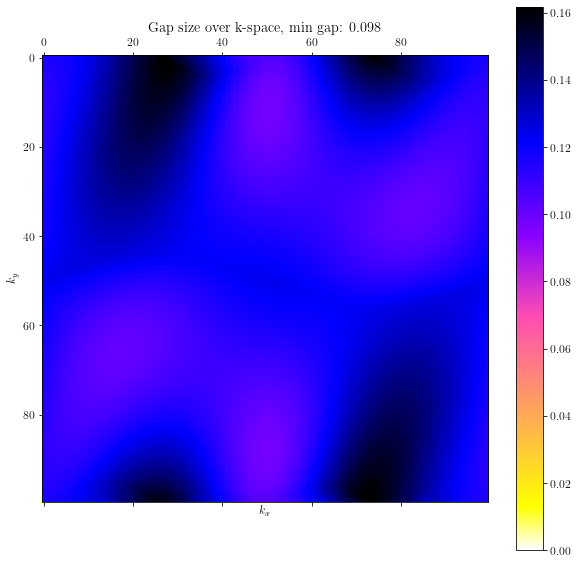

In [50]:
resolution = 100

# plot the gap over k space
Hk = k_hamiltonian_generator(lattice, coloring,ujk_winner,J)
print(analyse_hk(Hk, resolution))
g = gap_over_phase_space(Hk, resolution)

fig, ax = plt.subplots(figsize = (10,10))
cax = ax.matshow(g, cmap = 'gnuplot2_r',vmin = 0)
plt.colorbar(cax,ax=ax)
ax.set_title(f'Gap size over k-space, min gap: {np.min(g):.3f}')
ax.set_xlabel('$k_x$')
ax.set_ylabel('$k_y$')

Finally let's look at the fermionic band structure at the zero flux point

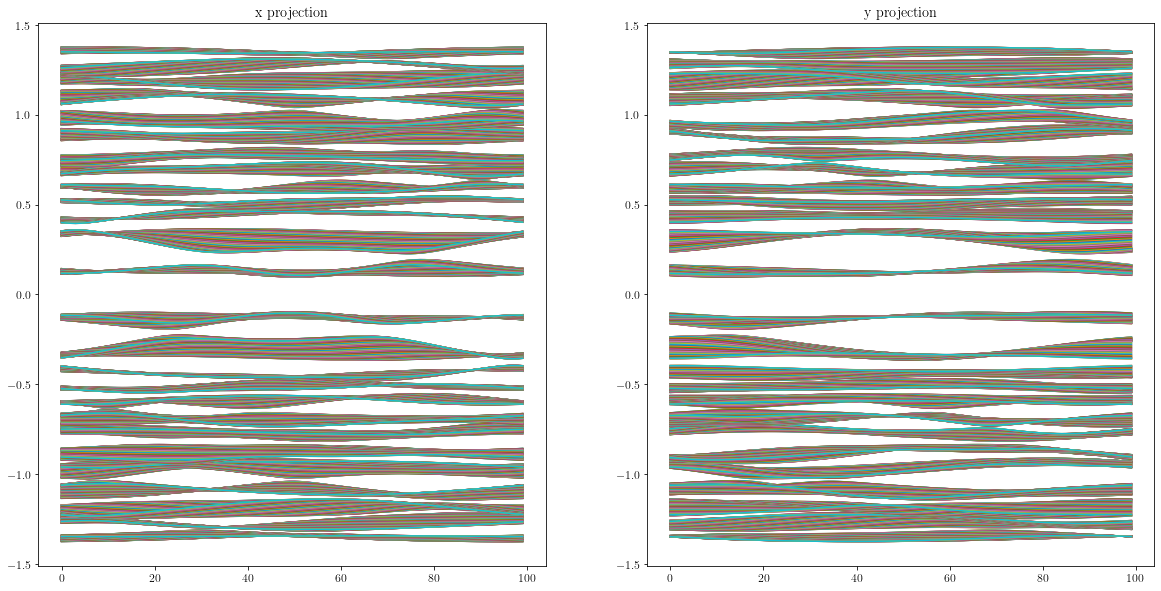

In [51]:
# plot the whole band structure

k_values = np.arange(resolution)*2*np.pi/resolution
KX,KY = np.meshgrid(k_values,k_values)
k_vals = np.concatenate([KX[:,:,np.newaxis],KY[:,:,np.newaxis]],axis=2)

def find_bands(k):
    h = Hk(k)
    vals = la.eigvalsh(h)
    return vals
bands = np.apply_along_axis(find_bands,2,k_vals)

fig, ax = plt.subplots(1,2,figsize = (20,10))


for n in range(bands.shape[2]):
    ax[0].set_title('x projection')
    ax[1].set_title('y projection')

    ax[0].plot(bands[:,:,n].T)    
    ax[1].plot(bands[:,:,n])


Now thats what I call Gapped flux sector 2022